## Entire Script

### Package Loading

In [51]:
from models.ModelBuilder import ModelBuilder
from models.Reaction import Reaction
from models.ReactionArchtype import ReactionArchtype
from models.ArchtypeCollections import *
from models.Utils import *
from models.DrugModelSpecification import DrugModelSpecification, Drug

import matplotlib.pyplot as plt
import seaborn as sns
import roadrunner
import numpy as np
import pandas as pd

# import scikit-learn
from sklearn.linear_model import LinearRegression
# tree models and support vector machines
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# import pearson correlation
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from copy import deepcopy

### Parameters 

In [52]:
import os 

### parameters 

## Generation of ground truth model 

model_name = 'drug_model_52'
o_random_seed = 4
no_observable_species = 5
no_feedback_regulations = 2
specie_value_range = (5, 5000)
param_range = (0.1, 10)
param_multiplier_range = (0.7, 1.3)


## Simulation parameters 

simulation_time = 1000 
simulation_step = 1000

## Feature data generation 

feature_generation_method = 'uniform'
feature_generation_extra_params = {'min': 0.1, 'max': 10}
feature_generation_size = 1000 
feature_generation_seed = 50 # if -1 then 'o_random_seed' is used
if feature_generation_seed == -1:
    feature_generation_seed = o_random_seed
    
## Data engineering parameters

# Suboptimal Model Generation 

'''
Options: 
- 'feedback_prune': removes feedback regulations from the model 
'''

# Engineering Feature Data 

data_engineering_method = 'last_time_point'
''' 
Options: 
- 'last_time_point' : only the last time point of the phosphorylated species is used
- 'dynamic_feature': computes the characteristic 'ten' dynamic feature for each specie data 
'''

# Drug parameters 

drugs = [Drug('D0', 500, 500, ['B2'], ['down'])]
dose_response_range = np.linspace(0, 100, 25)

## General parameters
parallelise = True
save_figures = True 
experiment_id = model_name + '_' + str(o_random_seed) + '_' + str(feature_generation_seed) + '_' + data_engineering_method
experiment_folder = 'experiments/' + experiment_id + '/'
if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

### Core Script

#### Block 1 - Generate Ground Truth Model

In [53]:
### Generate the ground truth model

model_spec = DrugModelSpecification()
model_spec.generate_specifications(o_random_seed, no_observable_species, no_feedback_regulations, verbose=0)
drug_0 = Drug('D0', 500, 500)
drug_0.add_regulation('B2', 'down')
model_spec.add_drug(drug_0)

G0 = model_spec.generate_network(model_name, specie_value_range, param_range, param_multiplier_range, random_seed=o_random_seed, verbose=0)

In [54]:
runner = roadrunner.RoadRunner(G0.get_sbml_model())
res = runner.simulate(0, simulation_time, simulation_step)

#### Block 2 - Dose Response Range on Default Model

In [55]:
# iterate through values of `dose_response_range` and simulate the model with the drug
response_data = []
Cp_data = []
# model_spec = DrugModelSpecification()
# model_spec.generate_specifications(o_random_seed, no_observable_species, no_feedback_regulations, verbose=0)
# drug_0 = Drug('D0', 500, 500)
# drug_0.add_regulation('B2', 'down')
# model_spec.add_drug(drug_0)
# G0 = model_spec.generate_network(model_name, specie_value_range, param_range, param_multiplier_range, random_seed=o_random_seed, verbose=0)
for dose in dose_response_range:
    ### Generate the ground truth model
    model_spec.clear_drugs()
    model_spec.add_drug(drug_0, dose)
    G0_temp = model_spec.generate_network(model_name, specie_value_range, param_range, param_multiplier_range, random_seed=o_random_seed, verbose=0)
    G0_temp = copy_over_params_states(G0, G0_temp)
    runner = roadrunner.RoadRunner(G0_temp.get_sbml_model())
    res = runner.simulate(0, simulation_time, simulation_step)
    # get the last time point of Cp 
    response = res['[Cp]'][-1]
    response_data.append(response)
    Cp_data.append(res['[Cp]'])

#### Block 3 - Systematic Generation of Suboptimal Models

In [56]:
## Depends on block 1

sub_model_count = 10 
pruned_edge_count = 1

print(model_spec.regulations)
# generate the suboptimal models
suboptimal_model_specs = []
suboptimal_models = []
for i in range(sub_model_count):
    new_model_spec, new_model = systematic_edge_pruning(model_spec, G0, pruned_edge_count, o_random_seed)
    print(new_model_spec.regulations)
    # print(len(new_model_spec.regulations))
    suboptimal_models.append(new_model)
    suboptimal_model_specs.append(new_model_spec)

[('C', 'A1'), ('B0', 'A2'), ('A0', 'B0'), ('A1', 'B1'), ('A2', 'B2'), ('A3', 'B3'), ('A4', 'B4'), ('D0', 'B2')]
[('C', 'A1'), ('B0', 'A2'), ('A0', 'B0'), ('A1', 'B1'), ('A3', 'B3'), ('A4', 'B4'), ('D0', 'B2')]
[('C', 'A1'), ('B0', 'A2'), ('A0', 'B0'), ('A1', 'B1'), ('A3', 'B3'), ('A4', 'B4'), ('D0', 'B2')]
[('C', 'A1'), ('B0', 'A2'), ('A0', 'B0'), ('A1', 'B1'), ('A3', 'B3'), ('A4', 'B4'), ('D0', 'B2')]
[('C', 'A1'), ('B0', 'A2'), ('A0', 'B0'), ('A1', 'B1'), ('A3', 'B3'), ('A4', 'B4'), ('D0', 'B2')]
[('C', 'A1'), ('B0', 'A2'), ('A0', 'B0'), ('A1', 'B1'), ('A3', 'B3'), ('A4', 'B4'), ('D0', 'B2')]
[('C', 'A1'), ('B0', 'A2'), ('A0', 'B0'), ('A1', 'B1'), ('A3', 'B3'), ('A4', 'B4'), ('D0', 'B2')]
[('C', 'A1'), ('B0', 'A2'), ('A0', 'B0'), ('A1', 'B1'), ('A3', 'B3'), ('A4', 'B4'), ('D0', 'B2')]
[('C', 'A1'), ('B0', 'A2'), ('A0', 'B0'), ('A1', 'B1'), ('A3', 'B3'), ('A4', 'B4'), ('D0', 'B2')]
[('C', 'A1'), ('B0', 'A2'), ('A0', 'B0'), ('A1', 'B1'), ('A3', 'B3'), ('A4', 'B4'), ('D0', 'B2')]
[('C',

In [57]:
# simulate the suboptimal models
suboptimal_Cp_data = []
for i in range(sub_model_count):
    runner = roadrunner.RoadRunner(suboptimal_models[i].get_sbml_model())
    s_res = runner.simulate(0, simulation_time, simulation_step)
    suboptimal_Cp_data.append(s_res['[Cp]'])

G0_Cp = res['[Cp]']

### Figure Generation and Visualisation

#### Output 1 - Visualising dose response of target to drug

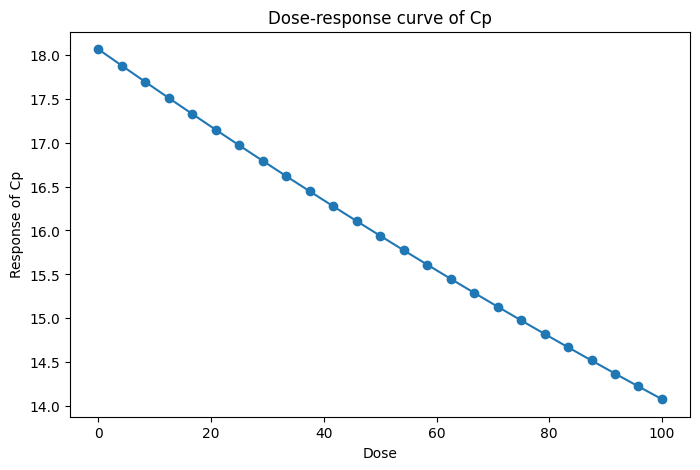

In [58]:
plt.figure(figsize=(8,5))
# plot the dose-response curve 
plt.plot(dose_response_range, response_data, 'o-')
plt.xlabel('Dose')
plt.ylabel('Response of Cp')
plt.title('Dose-response curve of Cp')
plt.show()
# if save_figures:
    # plt.savefig(experiment_folder + 'dose_response_curve.png')


#### Output 2 - Visualising the dynamic of Cp over drug response range

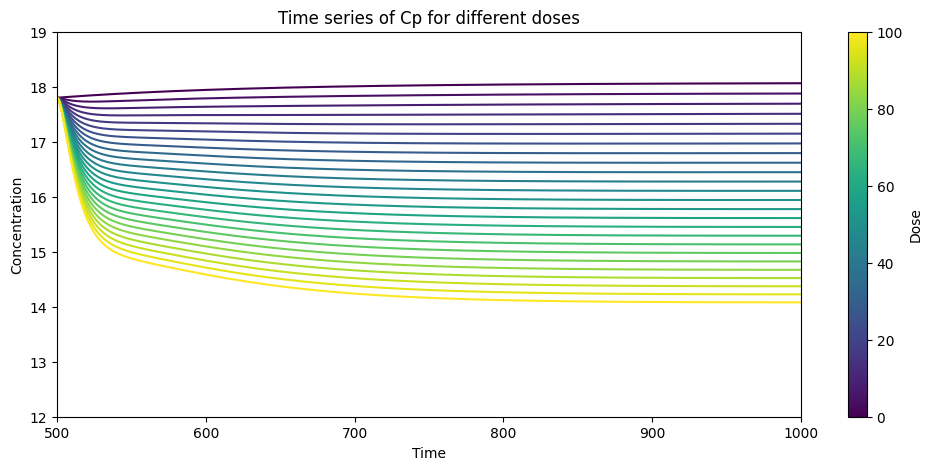

In [ ]:
import matplotlib.colors as mcolors
plt.figure(figsize=(12, 5))
# plot the Cp time series for each dose and choose a viridis colormap
norm = mcolors.Normalize(vmin=min(dose_response_range), vmax=max(dose_response_range))  # Ensure the range matches your doses
cmap = plt.cm.viridis
for i, dose in enumerate(dose_response_range):
    plt.plot(res['time'], Cp_data[i], label='Dose: ' + str(dose), color=cmap(norm(dose)))
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Time series of Cp for different doses')
# plt.colorbar(plt.cm.ScalarMappable(cmap='viridis')) 
# the colorbar needs to display the dose values 
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm)
cbar.set_label('Dose')
plt.xlim(500,1000)
plt.ylim(12,19)
plt.show()

#### Output 3 - Visualising Cp and C in ground truth model

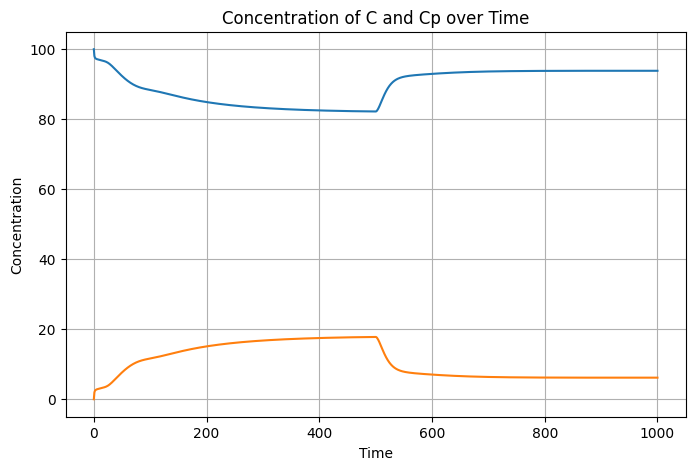

In [60]:
# === PLOT: Visible States Over Time ===

# Initialize RoadRunner and simulate the model
runner = roadrunner.RoadRunner(G0.get_sbml_model())
res = runner.simulate(0, simulation_time, simulation_step)

# Define key observable states
visible_states = ['C', 'Cp']

# Plot the concentration of visible states over time
plt.figure(figsize=(8, 5))
for state in visible_states:
    plt.plot(res['time'], res[f'[{state}]'], label=state)

# Formatting the plot
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.title("Concentration of C and Cp over Time")
plt.grid(True)

if save_figures:
    plt.savefig(experiment_folder + 'Fig_01_C_Cp_time_course_ground_truth.png')
plt.show()

#### Output 4 - Cp dynamics in different suboptimal models

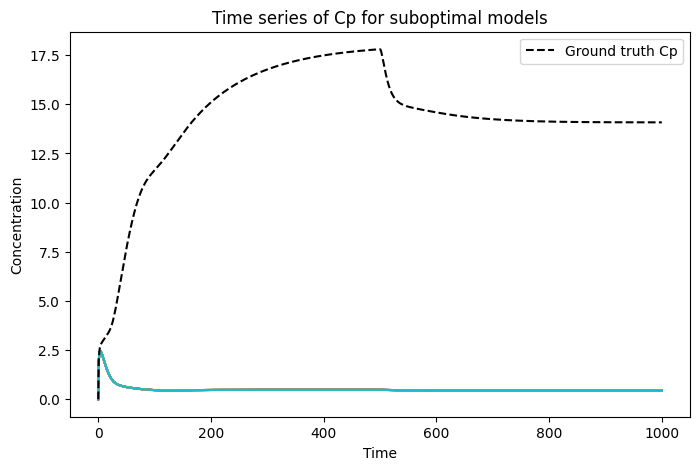

In [61]:
# plot the Cp time series for suboptimal_Cp_data and G0_Cp 

plt.figure(figsize=(8, 5))
for s0_data in suboptimal_Cp_data:
    plt.plot(res['time'], s0_data)
    
plt.plot(res['time'], G0_Cp, 'k--', label='Ground truth Cp')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Time series of Cp for suboptimal models')
plt.legend()
plt.show()

#### Output 4.5 - Cp Dynamics subplot for each suboptimal model

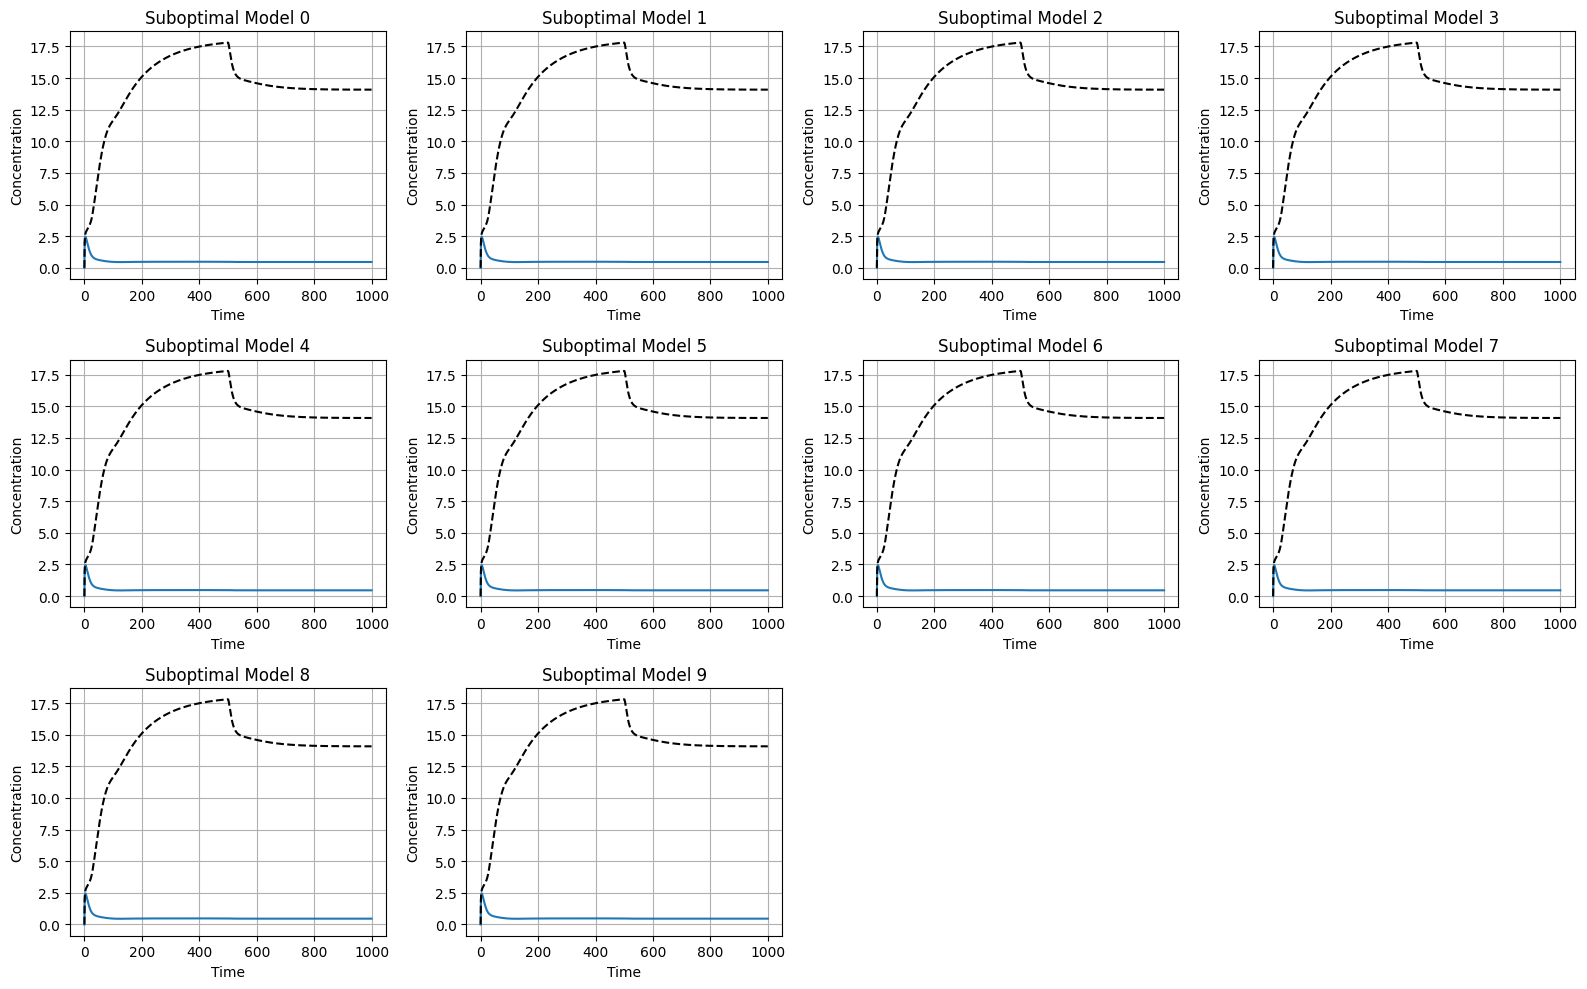

In [62]:
# plot each cp dynamic on a separate plot 

columns = 4
fig, axs = plt.subplots(len(suboptimal_Cp_data) // columns + 1, columns, figsize=(4 * columns, 5 * (len(suboptimal_Cp_data) // columns)))

for i, s0_data in enumerate(suboptimal_Cp_data):
    ax = axs[i // columns, i % columns]
    ax.plot(res['time'], s0_data)
    ax.plot(res['time'], G0_Cp, 'k--', label='Ground truth Cp')
    ax.set_title(f'Suboptimal Model {i}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Concentration')
    ax.grid(True)


for i in range(len(suboptimal_Cp_data), len(axs.flat)):
    fig.delaxes(axs.flatten()[i])
    
plt.tight_layout()
# if save_figures:
#     plt.savefig(experiment_folder + 'Fig_02_suboptimal_models_Cp_time_course.png')

plt.show()